In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0 (or your GPU index)
print(torch.cuda.get_device_name(0))  # Should print your GPU name

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# 1. Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # Adjust based on your tumor classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 2. Create MobileNetV1-based model
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        # Load pretrained MobileNetV1
        self.base_model = models.mobilenet_v2(pretrained=True)  # Note: PyTorch uses MobileNetV2 by default
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Modify the classifier
        num_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)

In [5]:
# 3. Data preprocessing and augmentation
def create_data_loaders(train_dir, val_dir):
    # Training transforms with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Validation transforms
    val_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader, train_dataset.classes

In [6]:
# 4. Training function
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

In [7]:
# 5. Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
# 6. Evaluation function
def evaluate_model(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Using device: cuda
Epoch 1/50:
Train Loss: 0.6128, Train Acc: 75.47%
Val Loss: 0.5730, Val Acc: 77.25%
Epoch 2/50:
Train Loss: 0.4999, Train Acc: 80.20%
Val Loss: 0.5583, Val Acc: 76.97%
Epoch 3/50:
Train Loss: 0.4684, Train Acc: 81.64%
Val Loss: 0.4884, Val Acc: 80.06%
Epoch 4/50:
Train Loss: 0.4628, Train Acc: 81.82%
Val Loss: 0.4850, Val Acc: 80.00%
Epoch 5/50:
Train Loss: 0.4491, Train Acc: 81.99%
Val Loss: 0.4938, Val Acc: 80.50%
Epoch 6/50:
Train Loss: 0.4340, Train Acc: 82.94%
Val Loss: 0.4690, Val Acc: 80.56%
Epoch 7/50:
Train Loss: 0.4330, Train Acc: 83.07%
Val Loss: 0.4569, Val Acc: 80.73%
Epoch 8/50:
Train Loss: 0.4333, Train Acc: 82.97%
Val Loss: 0.4597, Val Acc: 81.01%
Epoch 9/50:
Train Loss: 0.4331, Train Acc: 82.70%
Val Loss: 0.4464, Val Acc: 81.40%
Epoch 10/50:
Train Loss: 0.4360, Train Acc: 82.70%
Val Loss: 0.4459, Val Acc: 82.80%
Epoch 11/50:
Train Loss: 0.4204, Train Acc: 83.44%
Val Loss: 0.4459, Val Acc: 81.18%
Epoch 12/50:
Train Loss: 0.4193, Train Acc: 83.16%
Val 

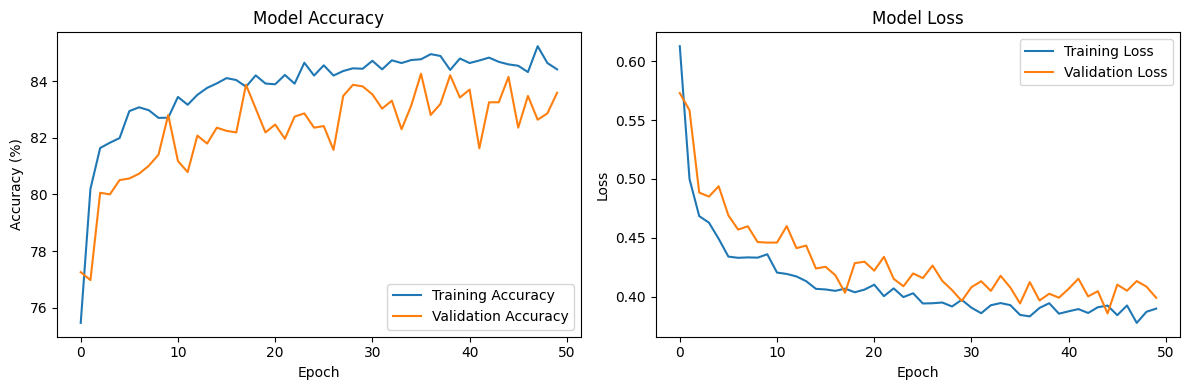


Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.73      0.78       450
  meningioma       0.68      0.72      0.70       400
     notumor       0.93      0.97      0.95       536
   pituitary       0.87      0.89      0.88       399

    accuracy                           0.84      1785
   macro avg       0.83      0.83      0.83      1785
weighted avg       0.84      0.84      0.83      1785



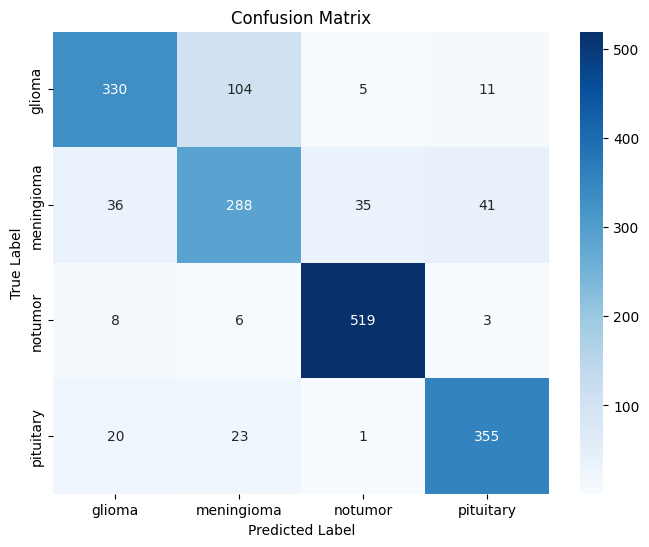

Model saved as 'brain_tumor_classifier.pth'


In [10]:
# 7. Main execution
def main():
    # Set dataset paths
    train_dir = r"C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\Training"  # Update this
    val_dir = r"C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\Testing"  # Update this
    
    # Create data loaders
    train_loader, val_loader, class_names = create_data_loaders(train_dir, val_dir)
    
    # Create and move model to device
    model = BrainTumorClassifier(NUM_CLASSES).to(DEVICE)
    
    # Train the model
    history = train_model(model, train_loader, val_loader)
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate the model
    evaluate_model(model, val_loader, class_names)
    
    # Save the model
    torch.save(model.state_dict(), 'brain_tumor_classifier.pth')
    print("Model saved as 'brain_tumor_classifier.pth'")

if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    main()

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# 1. Define the model class (must match your training code)
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=False)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)

In [3]:
# 2. Define image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [4]:
# 3. Load the model
def load_model(model_path, num_classes=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BrainTumorClassifier(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model, device

In [5]:
# 4. Predict function
def predict(model, image_tensor, device, class_names):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
    
    return predicted_class.item(), probabilities[0].cpu().numpy()

In [6]:
# 5. Visualize results
def show_prediction(image_path, predicted_class, probabilities, class_names):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[predicted_class]}')
    plt.axis('off')
    
    # Show probability distribution
    plt.subplot(1, 2, 2)
    plt.bar(class_names, probabilities)
    plt.title('Class Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
# 6. Test single image
def test_single_image(model_path, image_path, class_names):
    # Load model
    model, device = load_model(model_path)
    
    # Preprocess image
    image_tensor = preprocess_image(image_path)
    
    # Make prediction
    predicted_class, probabilities = predict(model, image_tensor, device, class_names)
    
    # Show results
    show_prediction(image_path, predicted_class, probabilities, class_names)
    
    # Print detailed results
    print(f"\nPrediction Results:")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print("Probabilities:")
    for name, prob in zip(class_names, probabilities):
        print(f"{name}: {prob:.4f}")

In [8]:
# 7. Test multiple images
def test_multiple_images(model_path, test_dir, class_names):
    model, device = load_model(model_path)
    
    correct = 0
    total = 0
    
    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_tensor = preprocess_image(img_path)
            
            predicted_class, probabilities = predict(model, image_tensor, device, class_names)
            
            true_class = class_names.index(class_name)
            if predicted_class == true_class:
                correct += 1
            total += 1
            
            print(f"\nImage: {img_name}")
            print(f"True Class: {class_name}")
            print(f"Predicted Class: {class_names[predicted_class]}")
            print(f"Confidence: {probabilities[predicted_class]:.4f}")
    
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"\nTest Accuracy: {accuracy:.2f}% ({correct}/{total})")

In [14]:
# 8. Main execution
def main():
    # Define your parameters
    model_path = 'brain_tumor_classifier.pth'  # Path to your saved model
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']  # Your classes
    
    # Choose testing mode
    test_mode = input("Enter 'single' to test one image or 'batch' to test multiple: ").lower()
    
    if test_mode == 'single':
        image_path = input("Enter the path to your test image: ")
        test_single_image(model_path, image_path, class_names)
    
    elif test_mode == 'batch':
        test_dir = input("Enter the path to your test directory: ")
        test_multiple_images(model_path, test_dir, class_names)
    
    else:
        print("Invalid mode selected. Please choose 'single' or 'batch'")

if __name__ == "__main__":
    main()

C:\Users\viraj\AppData\Local\Temp\ipykernel_21760\446810812.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Image: 1864.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.4084

Image: 1865.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.5923

Image: 1866.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.7574

Image: 1867.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.9000

Image: 1868.jpg
True Class: glioma
Predicted Class: meningioma
Confidence: 0.5307

Image: 1869.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.5170

Image: 1870.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.8551

Image: 1871.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.7337

Image: 1872.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.8904

Image: 1873.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.8003

Image: 1874.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.7889

Image: 1875.jpg
True Class: glioma
Predicted Class: glioma
Confidence: 0.4977

Image: 1876.jpg
True Class: glioma
Predicted Cl